In [55]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [195]:
# Nevin's pathname
pathname = '/Users/nevinaresh/Documents/CPET Research'
df = pd.read_parquet(pathname + '/combined_outcome_df.parquet')

outcomes_file = '/Users/nevinaresh/Documents/CPET Research/CPX database_outcomes_meds_10_22.xlsx'

#### Data preprocessing

In [9]:
# column names
for column_name in df.columns:
    print(column_name)

ID1
testDate
testTime
testDateTime
MRN
DOB
Height
AmbientTemp
Weight
TestDuration
AmbientRH
ExerciseDuration
firstName
lastName
Gender
Ergometer
Protocol
BarometricPress
Time
Rf
VT
VE
VO2
VCO2
RQ
O2exp
CO2exp
VE/VO2
VE/VCO2
VO2/Kg
METS
HR
VO2/HR
FeO2
FeCO2
FetO2
FetCO2
FiO2
FiCO2
SpO2
Power
Real_Power
Revolution
Speed
Grade
P_Syst
P_Diast
Phase
Ambient_Temp
RH_Amb
Analyzer_Pressure
PB
Ti
Te
Dyspnea
Leg Pain
ID
MRN-test date
Death
death_date
death_yrs
pre_arrhythm_surg
pre_arrhythm_surg_date
pre_arrhythm_surg_yrs
pre_card_surg
pre_card_surg_date
pre_card_surg_yrs
pre_acute_coronary_syndrome
pre_acute_coronary_syndrome_date
pre_acute_coronary_syndrome_yrs
pre_acute_heart_failure
pre_acute_heart_failure_date
pre_acute_heart_failure_yrs
pre_acute_respiratory_failure
pre_acute_respiratory_failure_date
pre_acute_respiratory_failure_yrs
pre_afib_flut
pre_afib_flut_date
pre_afib_flut_yrs
pre_cardiac_arrest
pre_cardiac_arrest_date
pre_cardiac_arrest_yrs
pre_cardiogenic_shock
pre_cardiogenic_sho

In [13]:
# Age
df['Age'] = (df['testDateTime'] - df['DOB']).dt.days / 365

In [14]:
# Difference between 'TestDuration' and 'Max_Time'
df['Max_Time'] = df['Time'].apply(max)
df['TestDurationTimeMaxDifference'] = abs(df['TestDuration'] - df['Max_Time'])
df['TestDurationTimeMaxDifference'].describe()

count    2089.000000
mean        4.111058
std         4.627206
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max        33.000000
Name: TestDurationTimeMaxDifference, dtype: float64

**Time-series data preprocessing**

In [15]:
time_series_columns = ['Time', 'Rf', 'VT', 'VE', 'VO2', 'VCO2', 'RQ', 'O2exp', 'CO2exp', 'VE/VO2', 'VE/VCO2', 'VO2/Kg', 'METS', 'HR', 'VO2/HR', 'FeO2', 'FeCO2', 'FetO2', 'FetCO2', 'FiO2', 'FiCO2', 'SpO2', 'Power', 'Real_Power', 'Revolution', 'Speed', 'Grade', 'P_Syst', 'P_Diast', 'Phase', 'Ambient_Temp', 'RH_Amb', 'Analyzer_Pressure', 'PB', 'Ti', 'Te', 'Dyspnea', 'Leg Pain']

In [16]:
def filter_time_series_columns(df, time_series_columns, skip_column, nan_threshold, empty_list_threshold):
    df_filtered = df.copy()

    for col in time_series_columns:
        if col == skip_column:
            continue
        
        # Replace arrays with an empty array if the proportion of NaN values exceeds nan_threshold
        df_filtered[col] = df_filtered[col].apply(
            lambda x: np.array([]) if pd.isna(x).mean() > nan_threshold else x
        )

        # Drop columns if the proportion of empty array exceeds empty_list_threshold
        empty_array_count = df_filtered[col].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
        total_array_count = len(df_filtered[col])
        missing_array_proportion = empty_array_count / len(df_filtered[col])
        if missing_array_proportion > 0:
            print(f"Column {col} contains {missing_array_proportion*100:.1f}% empty arrays.")
            if missing_array_proportion > empty_list_threshold:
                df_filtered.drop(columns=[col], inplace=True)

    return df_filtered

In [19]:
df_filtered = filter_time_series_columns(df, time_series_columns, skip_column='Time', nan_threshold=0.10, empty_list_threshold=0.10)

Column HR contains 0.4% empty arrays.
Column VO2/HR contains 0.4% empty arrays.
Column Power contains 87.0% empty arrays.
Column Real_Power contains 88.8% empty arrays.
Column Revolution contains 88.8% empty arrays.
Column Speed contains 13.2% empty arrays.
Column Grade contains 13.2% empty arrays.
Column P_Syst contains 86.5% empty arrays.
Column P_Diast contains 86.5% empty arrays.
Column RH_Amb contains 13.2% empty arrays.
Column Dyspnea contains 86.8% empty arrays.
Column Leg Pain contains 100.0% empty arrays.


In [26]:
df_filtered

ID1   testDate  testTime              testDateTime         MRN  \
1221  MRN-00124420 2017-05-26   2:42 PM 2017-05-26 14:42:00-07:00    124420.0   
2390  MRN-00131672 2018-02-02   1:30 PM 2018-02-02 13:30:00-08:00    131672.0   
2594  MRN-00157545 2014-09-19   3:44 PM 2014-09-19 15:44:00-07:00    157545.0   
695   MRN-00589580 2017-08-22   1:03 PM 2017-08-22 13:03:00-07:00    589580.0   
137   MRN-00637900 2017-07-14   8:38 AM 2017-07-14 08:38:00-07:00    637900.0   
...            ...        ...       ...                       ...         ...   
170   MRN-90049156 2019-03-13  11:46 AM 2019-03-13 11:46:00-07:00  90049156.0   
1506  MRN-90053935 2016-08-10   1:52 PM 2016-08-10 13:52:00-07:00  90053935.0   
940   MRN-90061193 2018-12-28   2:04 PM 2018-12-28 14:04:00-08:00  90061193.0   
2483  MRN-98362346 2020-01-06  10:54 AM 2020-01-06 10:54:00-08:00  98362346.0   
2747  MRN-99561292 2019-12-23   1:25 PM 2019-12-23 13:25:00-08:00  99561292.0   

                           DOB  Height  AmbientTemp  Weight  TestDuration  \
1221 1950-08-22 00:00:00-07:00   175.3         23.0   81.65         628.0   
2390 1953-08-23 00:00:00-07:00   167.6         24.0   81.19         749.0   
2594 1948-03-12 00:00:00-08:00   175.3         21.0   93.40         479.0   
695  1959-03-07 00:00:00-08:00   177.8         23.0  103.87         615.0   
137  1959-04-24 00:00:00-08:00   170.2         22.0   55.34        1003.0   
...                        ...     ...          ...     ...           ...   
170  1971-11-08 00:00:00-08:00   157.5         23.0   58.51         620.0   
1506 1972-04-27 00:00:00-08:00   157.5         23.0   48.99         980.0   
940  1993-02-22 00:00:00-08:00   172.7         23.0   83.91         804.0   
2483 1994-05-26 00:00:00-07:00   182.9         24.0   66.22        1178.0   
2747 1948-09-30 00:00:00-07:00   172.7         20.0   83.01         700.0   

      ...  post_ventricular_fib_flut_date  post_ventricular_fib_flut_yrs  \
1221  ...                             NaT                            NaN   
2390  ...                             NaT                            NaN   
2594  ...                             NaT                            NaN   
695   ...                             NaT                            NaN   
137   ...                             NaT                            NaN   
...   ...                             ...                            ...   
170   ...                             NaT                            NaN   
1506  ...                             NaT                            NaN   
940   ...                             NaT                            NaN   
2483  ...                             NaT                            NaN   
2747  ...                             NaT                            NaN   

     post_ventricular_tachycardia post_ventricular_tachycardia_date  \
1221                          1.0                        2022-03-31   
2390                          1.0                        2021-08-13   
2594                          1.0                        2014-09-27   
695                           1.0                        2018-12-21   
137                           0.0                               NaT   
...                           ...                               ...   
170                           1.0                        2020-02-12   
1506                          0.0                               NaT   
940                           0.0                               NaT   
2483                          0.0                               NaT   
2747                          0.0                               NaT   

     post_ventricular_tachycardia_yrs composite_outcome composite_outcome_yrs  \
1221                             4.85               0.0                   NaN   
2390                             3.53               0.0                   NaN   
2594                             0.02               1.0                  0.37   
695                        

In [22]:
filtered_time_series_columns = [col for col in time_series_columns if col in df_filtered.columns
                               and col != 'Phase']

In [23]:
def calculate_statistics_for_columns(df, time_series_columns, skip_column):
    stats_df = df.copy()
    stats_column_names = []
    
    for col in time_series_columns:
        if col == skip_column:
            continue
            
        stats_df[f"{col}_min"] = stats_df[col].apply(lambda x: np.nanmin(x) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q1"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.25) if x.size != 0 else np.nan)
        #stats_df[f"{col}_median"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.50) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q3"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.75) if x.size != 0 else np.nan)
        stats_df[f"{col}_max"] = stats_df[col].apply(lambda x: np.nanmax(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_mean"] = stats_df[col].apply(lambda x: np.nanmean(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_std"] = stats_df[col].apply(lambda x: np.nanstd(x) if x.size != 0 else np.nan)
        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_column_names.extend([f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_df.drop(columns=[col], inplace=True)
        
    return stats_df, stats_column_names

In [24]:
stats_df, stats_column_names = calculate_statistics_for_columns(df_filtered, filtered_time_series_columns, skip_column='Time')

In [25]:
stats_df

ID1   testDate  testTime              testDateTime         MRN  \
1221  MRN-00124420 2017-05-26   2:42 PM 2017-05-26 14:42:00-07:00    124420.0   
2390  MRN-00131672 2018-02-02   1:30 PM 2018-02-02 13:30:00-08:00    131672.0   
2594  MRN-00157545 2014-09-19   3:44 PM 2014-09-19 15:44:00-07:00    157545.0   
695   MRN-00589580 2017-08-22   1:03 PM 2017-08-22 13:03:00-07:00    589580.0   
137   MRN-00637900 2017-07-14   8:38 AM 2017-07-14 08:38:00-07:00    637900.0   
...            ...        ...       ...                       ...         ...   
170   MRN-90049156 2019-03-13  11:46 AM 2019-03-13 11:46:00-07:00  90049156.0   
1506  MRN-90053935 2016-08-10   1:52 PM 2016-08-10 13:52:00-07:00  90053935.0   
940   MRN-90061193 2018-12-28   2:04 PM 2018-12-28 14:04:00-08:00  90061193.0   
2483  MRN-98362346 2020-01-06  10:54 AM 2020-01-06 10:54:00-08:00  98362346.0   
2747  MRN-99561292 2019-12-23   1:25 PM 2019-12-23 13:25:00-08:00  99561292.0   

                           DOB  Height  AmbientTemp  Weight  TestDuration  \
1221 1950-08-22 00:00:00-07:00   175.3         23.0   81.65         628.0   
2390 1953-08-23 00:00:00-07:00   167.6         24.0   81.19         749.0   
2594 1948-03-12 00:00:00-08:00   175.3         21.0   93.40         479.0   
695  1959-03-07 00:00:00-08:00   177.8         23.0  103.87         615.0   
137  1959-04-24 00:00:00-08:00   170.2         22.0   55.34        1003.0   
...                        ...     ...          ...     ...           ...   
170  1971-11-08 00:00:00-08:00   157.5         23.0   58.51         620.0   
1506 1972-04-27 00:00:00-08:00   157.5         23.0   48.99         980.0   
940  1993-02-22 00:00:00-08:00   172.7         23.0   83.91         804.0   
2483 1994-05-26 00:00:00-07:00   182.9         24.0   66.22        1178.0   
2747 1948-09-30 00:00:00-07:00   172.7         20.0   83.01         700.0   

      ...  PB_mean  PB_std Ti_min Ti_max   Ti_mean    Ti_std Te_min Te_max  \
1221  ...    762.0     0.0   0.43   4.03  1.189242  0.492491   0.61  11.35   
2390  ...    765.0     0.0   0.38   1.70  0.926987  0.276339   0.51   3.34   
2594  ...    757.0     0.0   0.76   2.16  1.260843  0.234373   0.87   4.98   
695   ...    763.0     0.0   0.54   2.62  1.090367  0.250601   0.67   4.41   
137   ...    762.0     0.0   0.30   3.09  0.980805  0.383926   0.47  10.39   
...   ...      ...     ...    ...    ...       ...       ...    ...    ...   
170   ...    766.0     0.0   0.32   7.24  1.065431  0.622124   0.27   5.26   
1506  ...    759.0     0.0   0.25   1.79  0.913417  0.223686   0.47   4.14   
940   ...    766.0     0.0   0.41   3.61  1.103515  0.414783   0.57  12.99   
2483  ...    773.0     0.0   0.41   8.86  1.436260  0.815958   0.60   9.51   
2747  ...    757.0     0.0   0.37   3.76  1.441934  0.452938   0.64   6.10   

       Te_mean    Te_std  
1221  1.849763  1.400563  
2390  1.461154  0.575884  
2594  1.640060  0.469851  
695   1.766651  0.570757  
137   1.454317  0.887719  
...        ...       ...  
170   1.595086  0.727757  
1506  1.296422  0.485880  
940   1.632355  1.320264  
2483  1.638494  0.942991  
2747  1.905755  0.867975  

[2089 rows x 296 columns]

### Disease

In [196]:
cpx = pd.read_excel(outcomes_file, sheet_name="CPX")
hcm = cpx[cpx['CPX_diagnosis_Cat1'] == 'HCM']
hcm_mrn = hcm['MRN']
hf = cpx[cpx['CPX_diagnosis_Cat1'] == 'HF']
hf_mrn = hf['MRN']
cong = cpx[cpx['CPX_diagnosis_Cat1'] == 'Cong']
cong_mrn = cong['MRN']

In [199]:
hcm_idx = stats_df[stats_df['MRN'].isin(hcm_mrn)].index
hf_idx = stats_df[stats_df['MRN'].isin(hf_mrn)].index
cong_idx = stats_df[stats_df['MRN'].isin(cong_mrn)].index

#### Exploratory data analysis

In [27]:
outcome_columns = ['Death', 'composite_outcome']
feature_columns = stats_column_names + ['Gender', 'Age', 'Height', 'Weight', 'TestDuration', 'ExerciseDuration', 'BarometricPress', 'AmbientTemp', 'AmbientRH']

In [28]:
selected_df = stats_df[outcome_columns + feature_columns]

In [31]:
selected_df

Death  composite_outcome  Rf_min  Rf_max    Rf_mean    Rf_std    VT_min  \
1221    0.0                0.0    4.68   46.88  23.186256  7.471942  0.223000   
2390    0.0                0.0   12.17   57.14  28.117372  9.553282  0.209000   
2594    0.0                1.0    9.29   34.29  21.599578  4.452925  0.397747   
695     0.0                0.0   10.77   40.82  22.623349  6.626090  0.480000   
137     0.0                0.0    5.47   63.16  27.769024  8.471721  0.221000   
...     ...                ...     ...     ...        ...       ...       ...   
170     0.0                0.0    6.86   64.52  24.758793  6.835277  0.049000   
1506    0.0                0.0   12.47   66.67  28.932362  7.061500  0.208000   
940     0.0                0.0    4.12   52.17  25.834812  8.814149  0.086000   
2483    0.0                0.0    4.89   48.39  23.734130  9.678859  0.071000   
2747    0.0                0.0    8.13   52.17  20.489953  7.865499  0.375000   

        VT_max   VT_mean    VT_std  ...    Te_std  Gender        Age  Height  \
1221  3.624000  2.290934  0.735377  ...  1.400563    Male  66.805479   175.3   
2390  1.335000  0.880795  0.245026  ...  0.575884  Female  64.490411   167.6   
2594  3.061634  1.175560  0.417608  ...  0.469851    Male  66.567123   175.3   
695   2.983000  1.488326  0.481676  ...  0.570757    Male  58.501370   177.8   
137   2.773000  1.287393  0.534072  ...  0.887719  Female  58.263014   170.2   
...        ...       ...       ...  ...       ...     ...        ...     ...   
170   1.469000  0.658435  0.208810  ...  0.727757  Female  47.375342   157.5   
1506  2.085000  0.883601  0.332816  ...  0.485880  Female  44.317808   157.5   
940   3.681000  1.829147  0.900927  ...  1.320264    Male  25.863014   172.7   
2483  3.637000  1.518694  0.604664  ...  0.942991    Male  25.632877   182.9   
2747  2.659000  1.423330  0.397270  ...  0.867975  Female  71.276712   172.7   

      Weight  TestDuration  ExerciseDuration  BarometricPress  AmbientTemp  \
1221   81.65         628.0             379.0              762         23.0   
2390   81.19         749.0             591.0              765         24.0   
2594   93.40         479.0             347.0              757         21.0   
695   103.87         615.0             176.0              763         23.0   
137    55.34        1003.0             512.0              762         22.0   
...      ...           ...               ...              ...          ...   
170    58.51         620.0             210.0              766         23.0   
1506   48.99         980.0             520.0              759         23.0   
940    83.91         804.0             348.0              766         23.0   
2483   66.22        1178.0             432.0              773         24.0   
2747   83.01         700.0             263.0              757         20.0   

      AmbientRH  
1221       44.0  
2390       36.0  
2594       67.0  
695        58.0  
137        56.0  
...         ...  
170        23.0  
1506       56.0  
940        18.0  
2483       32.0  
2747       41.0  

[2089 rows x 115 columns]

In [32]:
# Number of rows with at least one missing value
(selected_df.isnull().sum(axis=1) > 0).sum()

8

In [33]:
selected_df.isnull().sum().sort_values(ascending=False).head(20)

VO2/HR_std     8
VO2/HR_max     8
HR_min         8
HR_max         8
HR_std         8
VO2/HR_min     8
HR_mean        8
VO2/HR_mean    8
FiCO2_mean     0
FetCO2_std     0
FiCO2_std      0
SpO2_min       0
FiCO2_max      0
FiCO2_min      0
FiO2_std       0
FiO2_mean      0
FiO2_max       0
FiO2_min       0
FetO2_std      0
FetCO2_mean    0
dtype: int64

In [34]:
data = selected_df.dropna(axis=0, how='any')

In [35]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

In [36]:
data['BarometricPress'] = data.BarometricPress.astype(int)

In [37]:
categorical_columns = ['Death', 'composite_outcome', 'Gender']
numerical_columns = [col for col in data.columns if col not in categorical_columns]

**Correlation heatmap**

In [38]:
corr_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']

In [39]:
# Pearson correlation for numerical features
numerical_corr = data[corr_numerical_columns].corr(method='pearson')

In [41]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [42]:
# Cramér's V for categorical features
categorical_corr = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        categorical_corr.loc[col1, col2] = cramers_v(data[col1], data[col2])

In [43]:
# Point-Biserial Correlation for categorical-numerical Columns
categorical_numerical_corr = pd.DataFrame(index=categorical_columns, columns=corr_numerical_columns)
for cat_col in categorical_columns:
    for num_col in corr_numerical_columns:
        categorical_numerical_corr.loc[cat_col, num_col] = stats.pointbiserialr(data[cat_col], data[num_col])[0]

In [44]:
full_corr_matrix = pd.concat([
    pd.concat([categorical_corr, categorical_numerical_corr.T], axis=0),
    pd.concat([numerical_corr, categorical_numerical_corr], axis=0)
], axis=1).fillna(0).round(1)

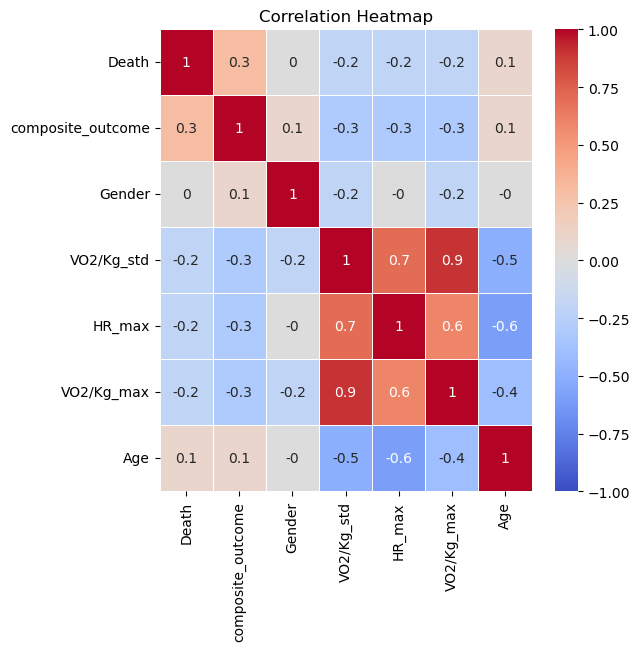

In [48]:
plt.figure(figsize=(6, 6))
sns.heatmap(full_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Frequency distribution**

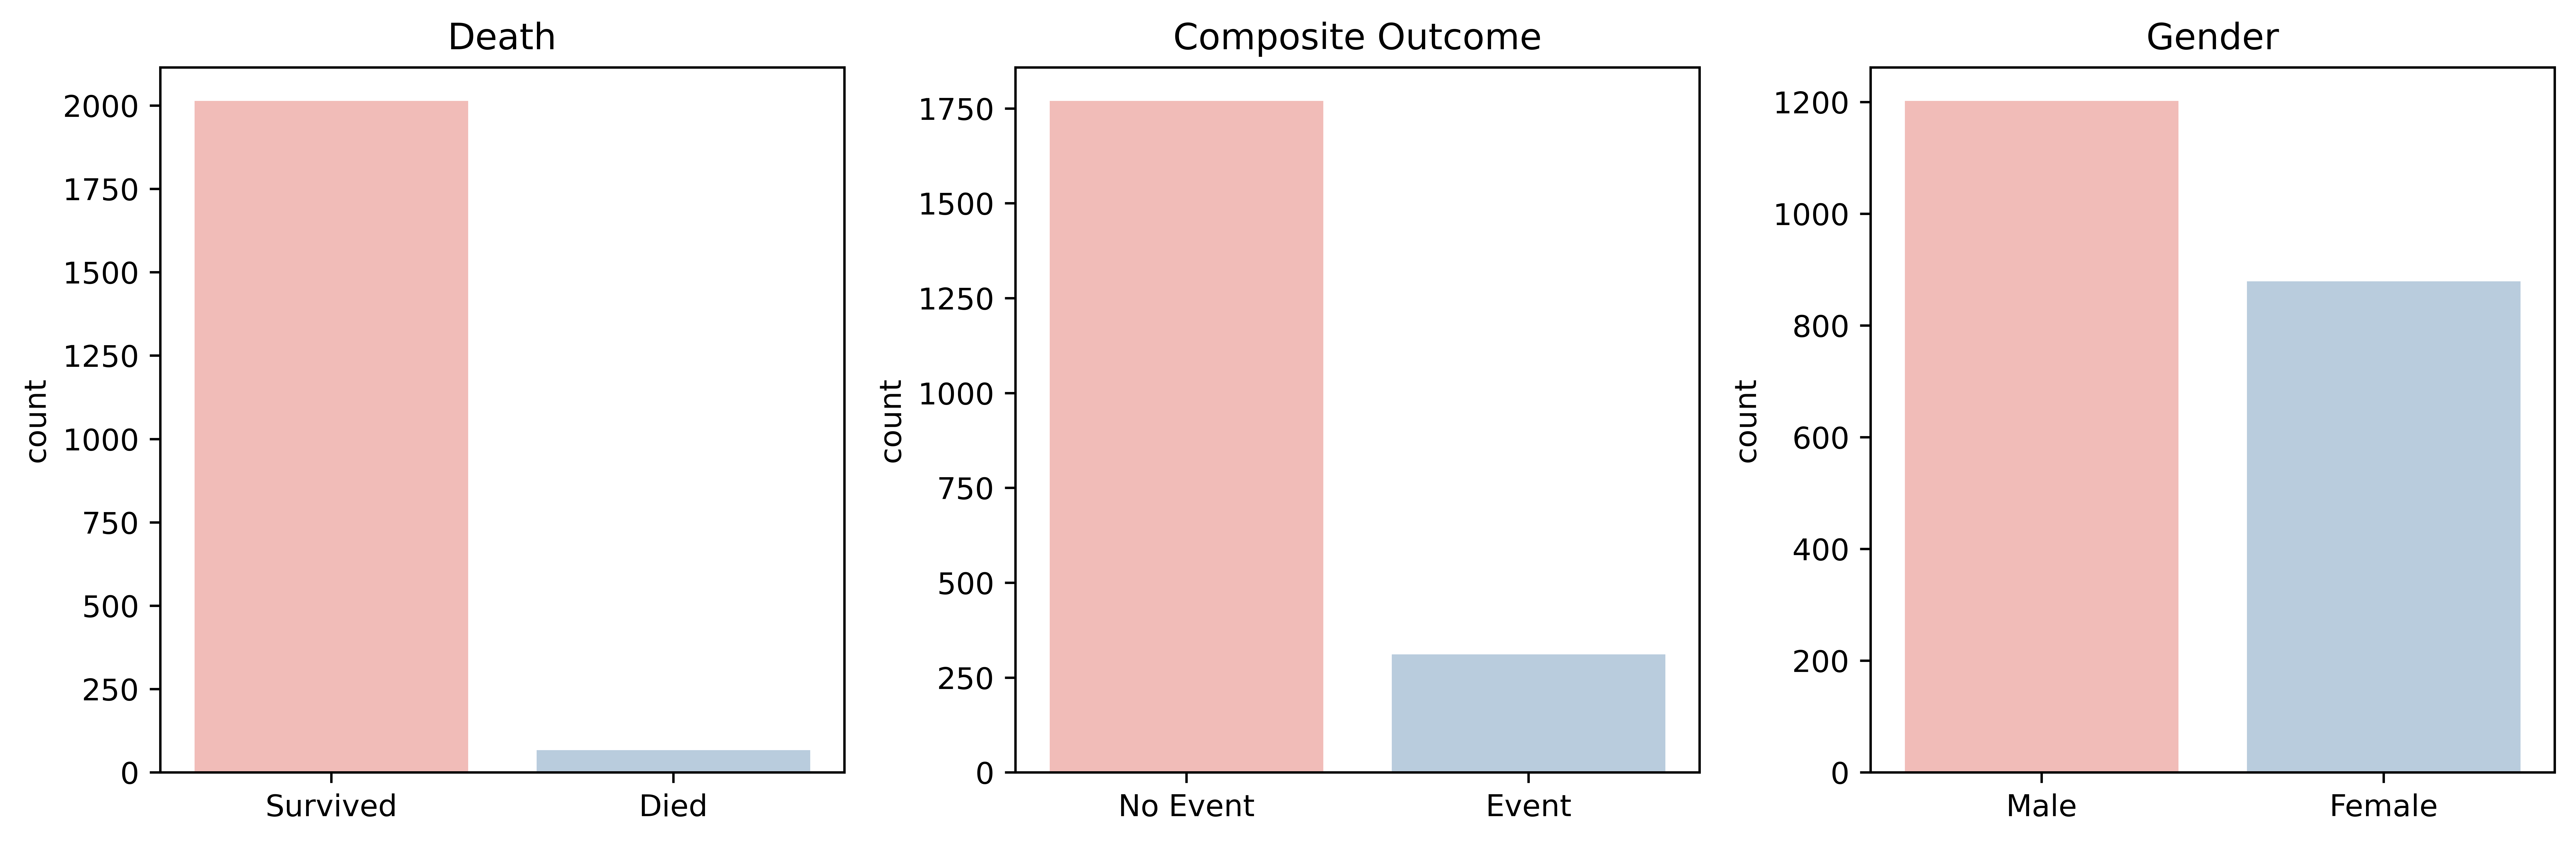

In [49]:
cat_data = data.copy()
cat_data['Death'] = cat_data['Death'].map({1: 'Died', 0: 'Survived'})
cat_data['composite_outcome'] = cat_data['composite_outcome'].map({0: 'No Event', 1: 'Event'})
cat_data['Gender'] = cat_data['Gender'].map({0: 'Male', 1: 'Female'})

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=800)
ax_title_pairs_categorical = zip(axs.flat, categorical_columns)
for ax, title in ax_title_pairs_categorical:
    sns.countplot(x=title, data=cat_data, palette='Pastel1', ax=ax)
    if title == "composite_outcome":
        ax.set_title("Composite Outcome")
    else:
        ax.set_title(title)
    ax.set_xlabel('')
plt.tight_layout()

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='Death')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='Survived')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Died')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

In [51]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='composite_outcome')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='No event')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Event')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

#### Model development

In [52]:
# seed_val = 66
seed_val = 123

**Data splitting**

In [53]:
features = data[feature_columns]
# outcome = data['Death']
outcome = data['composite_outcome']

In [56]:
x_train, x_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)
list(map(lambda x: x.shape, [features, outcome, x_train, x_test, y_train, y_test]))

[(2081, 113), (2081,), (1456, 113), (625, 113), (1456,), (625,)]

In [57]:
# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the training set:")
print((pd.Series(y_train).value_counts() / len(y_train)).round(2))

# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the test set:")
print((pd.Series(y_test).value_counts() / len(y_test)).round(2))


Proportion of each class for the outcome in the training set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64

Proportion of each class for the outcome in the test set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64


**Feature importance**

In [180]:
import xgboost as xgb
import shap
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, f1_score
from typing import Union
from sklearn.utils import resample
from sklearn.calibration import calibration_curve

In [224]:
# XGB model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [225]:
y_pred = model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[506,  26],
       [ 64,  29]])

In [226]:
# SHAP value for feature importance
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

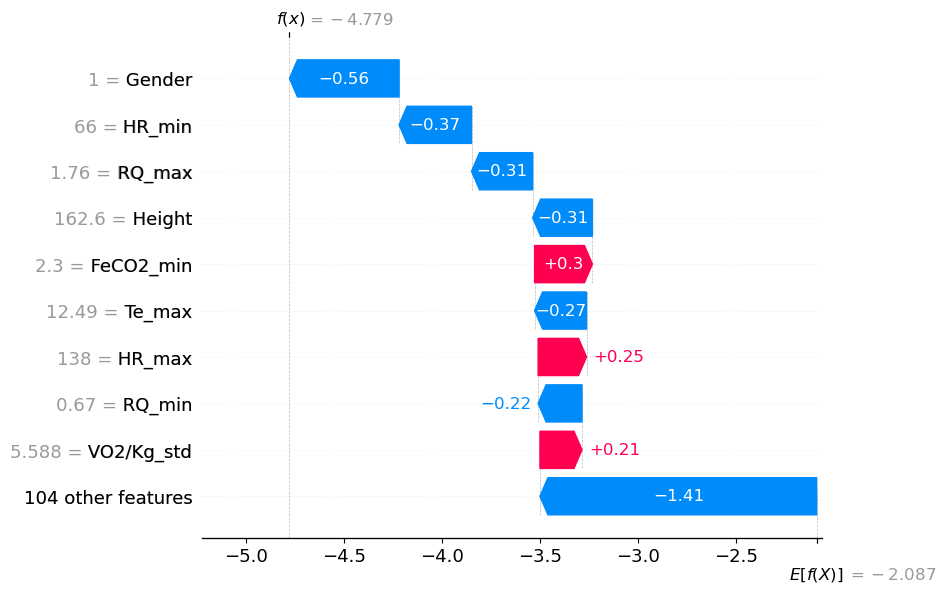

In [62]:
# Waterfall for the first patient
shap.plots.waterfall(shap_values[0])

In [63]:
shap.plots.initjs()

In [64]:
# Forceplot for the first patient
shap.plots.force(shap_values[0])
# Forceplot for the first 100 patients
#shap.plots.force(shap_values[0:100])

In [65]:
# Mean SHAP value
shap_values_df = pd.DataFrame({"feature_names": shap_values.feature_names, "values": np.mean(np.abs(shap_values.values), axis=0)}).sort_values(by="values", ascending=False)

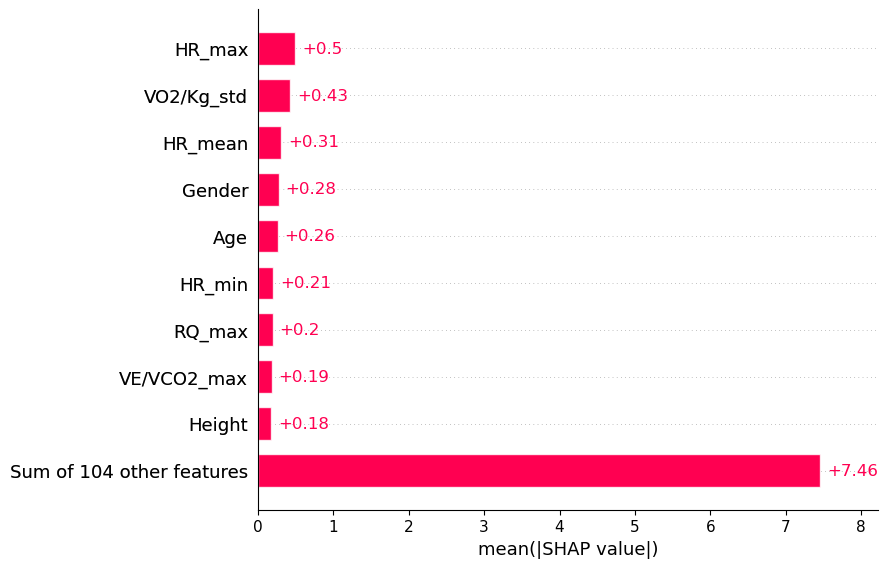

In [66]:
# Mean SHAP value for feature importance
shap.plots.bar(shap_values, max_display=10)

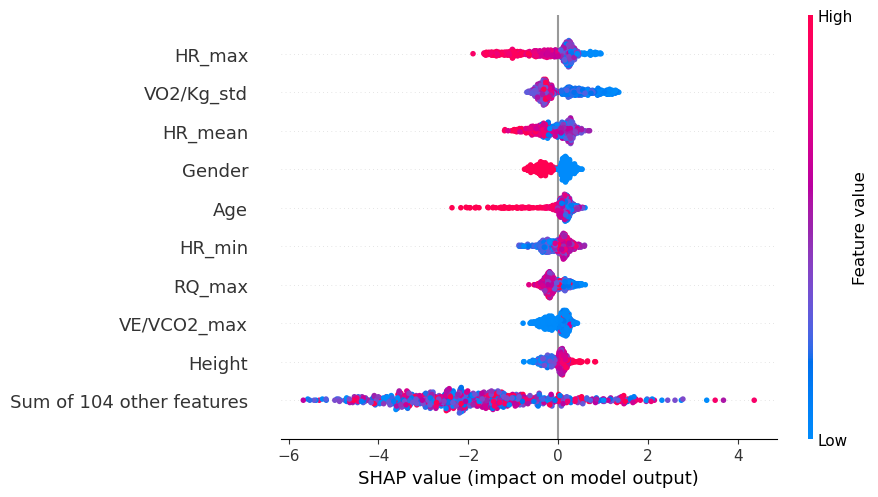

In [67]:
# Beeswarm plot for feature importance
shap.plots.beeswarm(shap_values, max_display=10)

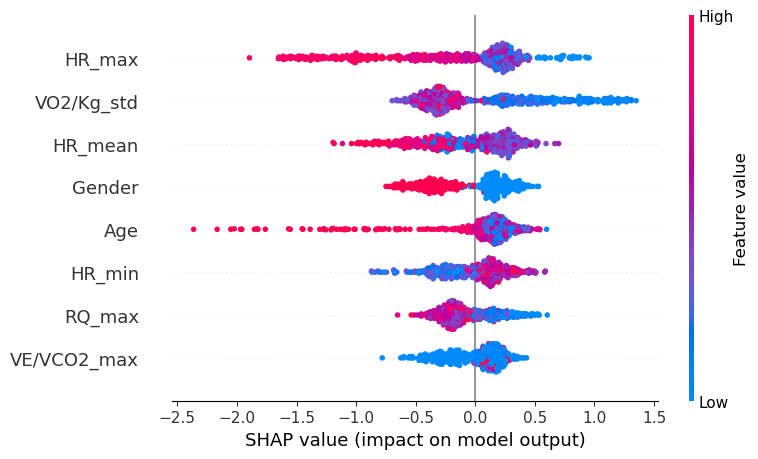

In [68]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8)

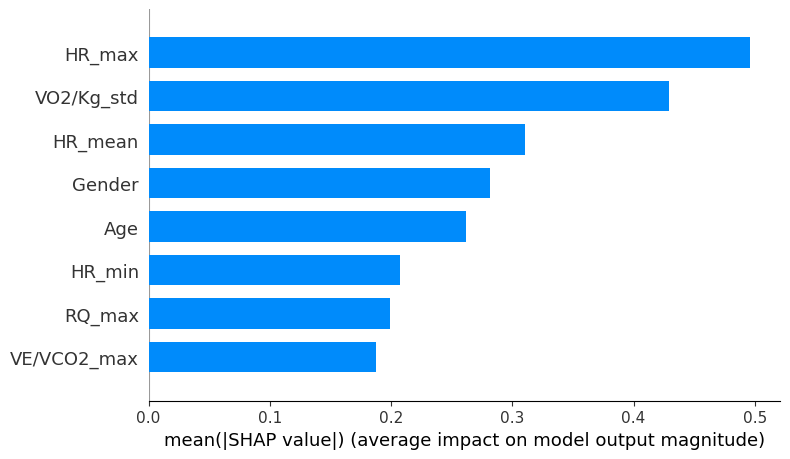

In [69]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8, plot_type='bar')

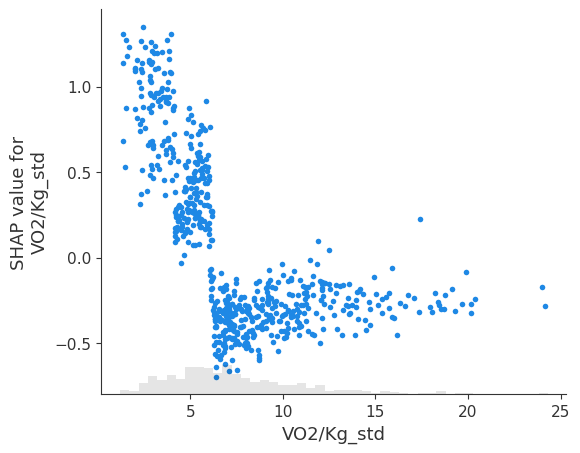

In [70]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"])

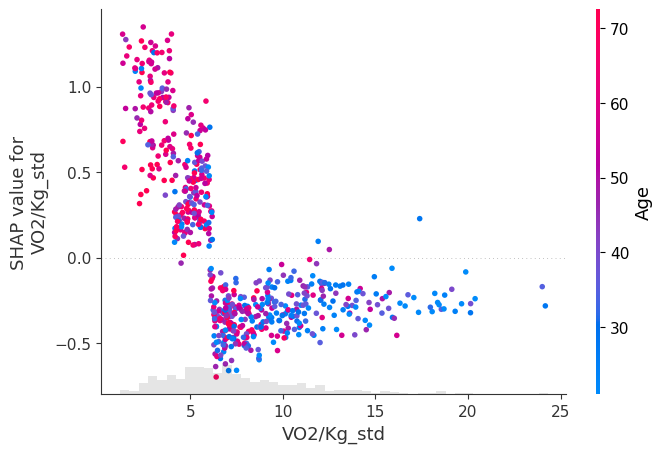

In [71]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"], color=shap_values[:, "Age"])

#### Prediction

In [227]:
# Predicted probablity
y_prob = model.predict_proba(x_test)[:,1] # Probabilities for the positive class

**Youden's index**

In [78]:
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Youden's Index for each threshold
youden_index = tpr - fpr

# Find the optimal threshold (the one that maximizes Youden's Index)
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print(f'Optimal Cut-off Threshold using Youden\'s Index: {optimal_threshold:.4f}')

Optimal Cut-off Threshold using Youden's Index: 0.0526


**Predicted outcome**

In [217]:
# Predicted outcome
# y_pred = (y_prob >= optimal_threshold).astype(int)
y_pred = model.predict(x_test)

In [80]:
# Group by predicted outcome and summarize the distribution of 'Death'
x_test_result = x_test.copy()
x_test_result['y_pred'] = y_pred
x_test_result['Death'] = data.loc[x_test_result.index, 'Death']
x_test_result['composite_outcome'] = data.loc[x_test_result.index, 'composite_outcome']

In [81]:
x_test_result.groupby('y_pred')['Death'].value_counts().unstack(fill_value=0)

Death   0.0  1.0
y_pred          
0       561    9
1        49    6

In [82]:
x_test_result.groupby('composite_outcome')['Death'].value_counts().unstack(fill_value=0)

Death              0.0  1.0
composite_outcome          
0.0                525    7
1.0                 85    8

#### Model performance

**Confusion matrix**

In [218]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[506,  26],
       [ 64,  29]])

In [219]:
tn, fp, fn, tp = conf_mat.ravel()

# Precision (Positive Predictive Value)
precision = tp / (tp + fp)

# Recall (Sensitivity)
recall = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Sensitivity (same as recall)
sensitivity = recall

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# Positive Predictive Value (PPV)
ppv = precision  # Same as precision

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Printing all the metrics
print(f'Precision (PPV): {precision:.3f}')
print(f'Recall (Sensitivity): {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'Sensitivity: {sensitivity:.3f}')
print(f'Negative Predictive Value (NPV): {npv:.3f}')
print(f'Positive Predictive Value (PPV): {ppv:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')

Precision (PPV): 0.527
Recall (Sensitivity): 0.312
Specificity: 0.951
Sensitivity: 0.312
Negative Predictive Value (NPV): 0.888
Positive Predictive Value (PPV): 0.527
Accuracy: 0.856
F1 Score: 0.392


In [228]:
def confusion_plot(matrix, labels=None):
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

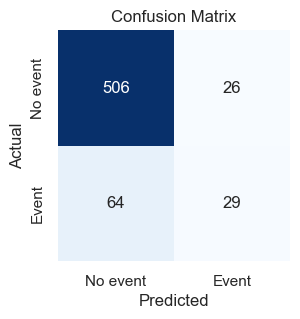

In [229]:
confusion_plot(conf_mat, labels=['No event', 'Event'])

**AUC value & ROC curve**

In [230]:
def calc_roc_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:

    # Define thresholds: 1000 equally spaced values between 0 and 1
    thresholds = np.linspace(0, 1, 1000)
    
    # Initialize arrays for FPR and TPR
    fprs = []
    tprs = []
    
    # Loop over each threshold and calculate FPR and TPR
    for threshold in thresholds:
        # Predicted positive based on threshold
        predicted_positive = (y_prob >= threshold).astype(int)
        
        # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
        tp = np.sum((predicted_positive == 1) & (y_true == 1))
        fp = np.sum((predicted_positive == 1) & (y_true == 0))
        fn = np.sum((predicted_positive == 0) & (y_true == 1))
        tn = np.sum((predicted_positive == 0) & (y_true == 0))
        
        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity or recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1 - Specificity
        
        # Append the calculated rates
        tprs.append(tpr)
        fprs.append(fpr)

    fprs = np.array(fprs)
    tprs = np.array(tprs)
    
    return fprs, tprs

In [231]:
def display_roc_curve(
    fpr_tpr_list: list[tuple[np.ndarray, np.ndarray]],
    model_name_list: list[str],
    filename: Union[str, None] = None,
):
    # Plot the ROC curve using seaborn
    sns.set()
    plt.figure()
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    # Plot each ROC curve
    for (fpr, tpr), model_name in zip(fpr_tpr_list, model_name_list):
        plt.plot(fpr, tpr, label=model_name, linewidth=2)
    
    # Add the diagonal line for random performance
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Performance')

    # Set axis labels and title
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

    # Add legend
    plt.legend(fontsize=12, loc='lower right')

    # Adjust layout and save the plot if a filename is provided
    plt.tight_layout()
    if filename:
        plt.savefig(filename, format='png')

    # Show the plot
    plt.show()

<Figure size 640x480 with 0 Axes>

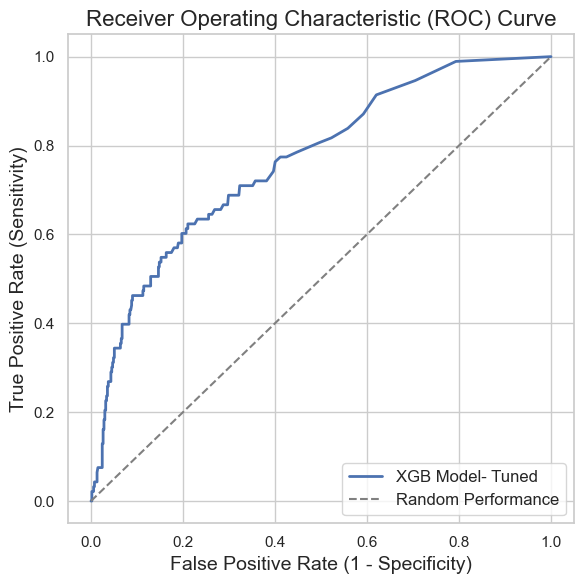

In [232]:
fpr, tpr = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fpr, tpr)],["XGB Model- Tuned"])

In [233]:
# Bootstrap function for calculating confidence intervals of AUC
def bootstrap_auc(y_true, y_prob, n_iterations=1000, random_state=None):
    auc_scores = []

    for _ in range(n_iterations):
        X_resample, y_resample = resample(y_prob, y_true, n_samples=len(y_true), random_state=random_state)
        auc_scores.append(roc_auc_score(y_resample, X_resample))
        
    auc_lower = np.percentile(auc_scores, 2.5)
    auc_upper = np.percentile(auc_scores, 97.5)
    
    # Return the mean values of C-index and AUC, along with their confidence intervals
    return auc_lower, auc_upper

In [234]:
# Bootstrap to calculate C-index, AUC and their 95% CI
#auroc = auc(fpr, tpr)
auroc = roc_auc_score(y_test, y_prob)
auc_lower, auc_upper = bootstrap_auc(y_test, y_prob)
print(f"AUC: {auroc:.3f} (95% CI: {auc_lower:.3f} - {auc_upper:.3f})")

AUC: 0.768 (95% CI: 0.716 - 0.818)


### Hyperparameter Tuning

In [129]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

In [165]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.856
0.3918918918918919
0.6314778882690597


array([[506,  26],
       [ 64,  29]])

In [172]:
y_pred = model.predict(x_train)
print(roc_auc_score(y_train, y_pred))
confusion_matrix(y_train, y_pred)

1.0


array([[1238,    0],
       [   0,  218]])

In [146]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'max_depth': Integer(4, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

param_space = {
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 5),
    'reg_alpha': (0, 10),
    'reg_lambda': (1, 10),
}

In [184]:
opt = BayesSearchCV(model, search_spaces= param_space, n_iter= 120, scoring= 'roc_auc', cv=StratifiedKFold(n_splits=5), random_state=42)

In [185]:
overdone_control = DeltaYStopper(delta=0.0001) 
time_limit_control = DeadlineStopper(total_time=60*60*4)
opt.fit(x_train, y_train, callback=[overdone_control, time_limit_control])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      impor...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=123, ...),
              n_iter=120, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.6, 1.0), 'gamma': (0, 5),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'reg_alpha': (0, 10), 'reg_lambda': (1, 10),
                             'subsample': (0.6, 1.0)})

In [235]:
print(opt.best_params_)
y_pred = opt.best_estimator_.predict(x_train)
print(roc_auc_score(y_train, y_pred))
confusion_matrix(y_train, y_pred)

OrderedDict({'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.05818176914009971, 'max_depth': 3, 'n_estimators': 328, 'reg_alpha': 6, 'reg_lambda': 10, 'subsample': 0.6587052085594708})
0.5346778615997984


array([[1233,    5],
       [ 202,   16]])

In [237]:
print(opt.best_params_)
y_pred = opt.best_estimator_.predict(x_test)
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

OrderedDict({'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.05818176914009971, 'max_depth': 3, 'n_estimators': 328, 'reg_alpha': 6, 'reg_lambda': 10, 'subsample': 0.6587052085594708})
0.5151891826340044


array([[531,   1],
       [ 90,   3]])

<Figure size 640x480 with 0 Axes>

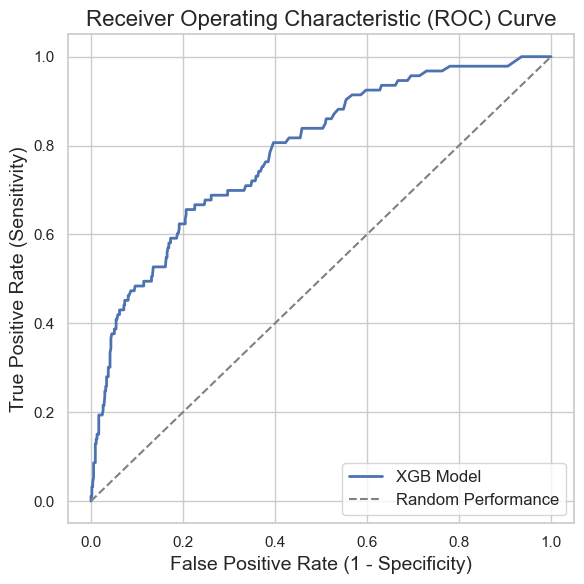

In [238]:
y_prob = opt.best_estimator_.predict_proba(x_test)[:,1]
fprs, tprs = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fprs, tprs)],["XGB Model"])

In [239]:
print(roc_auc_score(y_test, y_prob))

0.786350958040262


### Sensitivity Analysis

In [200]:
best_model = opt.best_estimator_

In [209]:
hcm_x_test = x_test[x_test.index.isin(hcm_idx)]
hcm_y_test = y_test[y_test.index.isin(hcm_idx)]

hf_x_test = x_test[x_test.index.isin(hf_idx)]
hf_y_test = y_test[y_test.index.isin(hf_idx)]

cong_x_test = x_test[x_test.index.isin(cong_idx)]
cong_y_test = y_test[y_test.index.isin(cong_idx)]

In [213]:
hcm_pred = best_model.predict(hcm_x_test)
hcm_prob = best_model.predict_proba(hcm_x_test)[:,1]

hf_pred = best_model.predict(hf_x_test)
hf_prob = best_model.predict_proba(hf_x_test)[:,1]

cong_pred = best_model.predict(cong_x_test)
cong_prob = best_model.predict_proba(cong_x_test)[:,1]

In [250]:
cong_x_test

Rf_min  Rf_max    Rf_mean     Rf_std    VT_min    VT_max   VT_mean  \
1804    9.17   51.72  30.528381   9.785149  0.392000  3.283000  1.695585   
252     8.38  150.00  28.015255  12.145518  0.137000  2.717000  1.106625   
2606    2.51   39.22  21.121136   3.908287  0.069000  1.502000  0.695269   
2197    5.64   40.54  21.802881   7.805264  0.321000  2.234000  1.554203   
1945    8.67  120.00  24.843437   9.334834  0.073000  2.824000  1.209538   
...      ...     ...        ...        ...       ...       ...       ...   
2726    3.05   43.80  16.583136   7.743835  0.215000  2.634000  1.198746   
2933    7.43   68.97  33.391179  15.430376  0.206004  2.281343  1.138978   
1477   10.19   58.25  33.030801  10.742023  0.324000  2.207000  1.445097   
1519    3.28   60.61  27.797609   9.927060  0.091000  1.699000  1.046428   
1051    8.80   67.42  24.407953   8.587538  0.131000  2.228000  1.455900   

        VT_std  VE_min   VE_max  ...    Te_std  Gender        Age  Height  \
1804  0.608174   5.280  124.700  ...  0.633203       0  31.172603   177.8   
252   0.431508   1.476   69.591  ...  0.650212       1  54.471233   170.2   
2606  0.288450   0.176   28.533  ...  0.872934       1  40.416438   149.9   
2197  0.408356   3.560   80.921  ...  0.993116       1  41.794521   162.6   
1945  0.537240   3.994   79.268  ...  0.610653       1  28.394521   162.6   
...        ...     ...      ...  ...       ...     ...        ...     ...   
2726  0.581992   1.784   88.730  ...  0.802880       1  32.717808   167.6   
2933  0.477133   4.349  109.393  ...  1.040958       0  25.805479   177.8   
1477  0.333492   8.176   79.733  ...  0.657866       1  31.909589   160.0   
1519  0.350689   1.267   67.292  ...  0.743737       1  55.854795   165.1   
1051  0.417139   1.724  118.286  ...  0.614239       0  56.000000   165.1   

      Weight  TestDuration  ExerciseDuration  BarometricPress  AmbientTemp  \
1804   84.82         858.0             408.0              763         22.0   
252    78.47         903.0             393.0              759         22.0   
2606   81.65         885.0             428.0              757         23.0   
2197   63.96         756.0             294.0              765         24.0   
1945   54.43         941.0             478.0              759         21.0   
...      ...           ...               ...              ...          ...   
2726   49.90         780.0             420.0              762         23.0   
2933   53.10         540.0             360.0              760         22.0   
1477   63.00         761.0             388.0              760         22.0   
1519   57.61         782.0             274.0              766         22.0   
1051   69.85        1026.0             381.0              767         21.0   

      AmbientRH  
1804       51.0  
252        56.0  
2606       55.0  
2197       44.0  
1945       60.0  
...         ...  
2726       51.0  
2933       56.0  
1477       56.0  
1519       56.0  
1051       42.0  

[151 rows x 113 columns]

In [214]:
print('HCM roc_auc: ' + str(roc_auc_score(hcm_y_test, hcm_prob)))
print('HF roc_auc: ' + str(roc_auc_score(hf_y_test, hf_prob)))
print('Cong roc_auc: ' + str(roc_auc_score(cong_y_test, cong_prob)))

HCM roc_auc: 0.6985294117647058
HF roc_auc: 0.8032436162870946
Cong roc_auc: 0.7176274018379281


In [ ]:
#Weight the samples
#train with just demographics (gender, age, height, weight) and compare
# add medication features

def mu(pi):
    return .8 + 0.2 * pi
def sigma(pi):
    return np.sqrt(0.0436 * pi**2 - 0.048*pi + 0.0144)
    #return np.sqrt(0.0244 * pi**2 - 0.0288*pi + 0.0144)
pi_val = np.linspace(0,1,100)

muval = mu(pi_val)
sigval = sigma(pi_val)

plt.plot(muval, sigval)
plt.xlabel('Expected Value')
plt.ylabel('Standard Deviation')

### Baseline Model

In [253]:
demographics = ['Age', 'Height', 'Weight', 'Gender']

In [256]:
demographics_feat = features[demographics]

In [257]:
x_train_demo, x_test_demo, y_train_demo, y_test_demo = train_test_split(demographics_feat, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)

In [262]:
model_demo = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
opt_demo = BayesSearchCV(model_demo, search_spaces= search_spaces, n_iter= 50, scoring= 'roc_auc', cv=3)

In [263]:
overdone_control = DeltaYStopper(delta=0.0001) 
time_limit_control = DeadlineStopper(total_time=60*60*4)
#opt.fit(X_train, y_train, callback=[overdone_control, time_limit_control])
opt_demo.fit(x_train_demo, y_train_demo, callback=[time_limit_control])

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                             'max_depth': Integer(low=4, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')})

In [264]:
y_prob_demo = opt_demo.best_estimator_.predict_proba(x_test_demo)[:,-1]
roc_auc_score(y_test_demo, y_prob_demo)

0.6402902417333656

**Calibration Curve**

In [112]:
def display_calibration_plot(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    filename: Union[str, None] = None,
):
    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='uniform'
    )
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    
    # Add labels and title
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    
    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, format='png')
    
    # Show the plot
    plt.show()

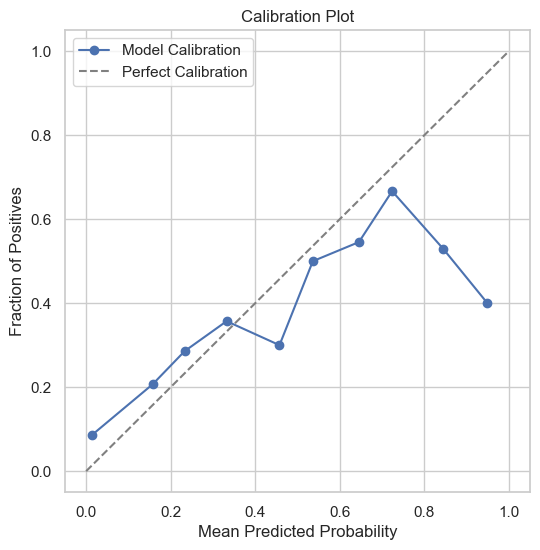

In [113]:
display_calibration_plot(y_test, y_prob)

In [114]:
data.shape

(2081, 115)